data_iob_v10.txt uses custom_tok2

In [1]:
# !pip install git+https://github.com/keras-team/keras.git -U
# !pip install seqeval
# !pip install "tensorflow==1.15.5"
# !pip install tensorflow-hub

In [2]:
import os
import sys
import numpy as np
from keras.models import Model, Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import TimeDistributed, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, Lambda
from keras.layers.merge import add
import tensorflow as tf
import tensorflow_hub as hub
# from sklearn.metrics import recall_score, precision_score
from seqeval.metrics import classification_report as classification_report_entity
from seqeval.metrics import precision_score, recall_score, f1_score
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
sys.path.append('../shared_functions')
from preprocess import read_file

# Prepare data

In [4]:
max_len = 42
batch_size = 32
EPOCHS = 5

In [5]:
loc = '../data_raw'

In [6]:
sentences = read_file(os.path.join(loc, 'data_iob_0911_train.txt'))
# label2idx = {}
# label_set = set()
# word_set = {}

# unique words and labels in data
# for sentence in sentences:
#     for token, label in sentence:
#         label_set.add(label)
#         word_set[token] = True
# word_set = list(word_set)
# n_words = len(word_set)
# print("number of unique words: ", n_words)

idx2label = {0: 'I-LOCATION',
             1: 'I-CUSTOMERNAME',
             2: 'B-LOCATION',
             3: 'B-CUSTOMERNAME',
             4: 'B-PERSON',
             5: 'I-PERSON',
             6: 'B-DATE',
             7: 'I-DATE',
             8: 'O'}

n_labels = len(idx2label)
print("number of unique labels: ", n_labels)

# mapping for labels
# for label in label_set:
#     label2idx[label] = len(label2idx)
# print(label2idx)

label2idx = {v: k for k, v in idx2label.items()}
# word2idx = {w: i + 1 for i, w in enumerate(word_set)}

print("total sentences: ", len(sentences))

number of unique labels:  9
total sentences:  10654


In [7]:
X_ori = [[w[0] for w in s] for s in sentences]

X = []
for seq in X_ori:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    X.append(new_seq)
X[0]

['limit',
 'to',
 'topvar',
 "'",
 's',
 'activities',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__']

In [8]:
y = [[label2idx[w[1]] for w in s] for s in sentences]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=label2idx["O"])
y[0]

array([8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int32)

In [9]:
X_tra, X_te, y_tra, y_te = train_test_split(X, y, test_size=0.2, random_state=2019)

X_tr, X_val, y_tr, y_val = train_test_split(X_tra, y_tra, test_size=0.1, random_state=2019)
X_tr = X_tr[0:int(np.floor(len(X_tr)/batch_size)*batch_size)]
X_val = X_val[0:int(np.floor(len(X_val)/batch_size)*batch_size)]
y_tr = y_tr[0:int(np.floor(len(y_tr)/batch_size)*batch_size)]
y_val = y_val[0:int(np.floor(len(y_val)/batch_size)*batch_size)]
print("training sentences: ", len(X_tr), "validation sentences: ", len(X_val))
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

training sentences:  7648 validation sentences:  832


# Build model

In [10]:
sess = tf.compat.v1.Session()
# K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [11]:
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),
                              "sequence_len": tf.constant(batch_size * [max_len])
                              },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [12]:
# Function to build model
def build_model():
    input_text = Input(shape=(max_len,), dtype="string")
    embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
    x = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(embedding)
    x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
    x = add([x, x_rnn])  # residual connection to the first biLSTMSS
    out = TimeDistributed(Dense(n_labels, activation="softmax"))(x)

    model = Model(input_text, out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
    model.summary()

    return model

In [13]:
# create a new folder called elmo_model under research_notebooks
filepath = "elmo_model/weights_elmo_lstm_train_v10_epoch_{epoch:02d}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,
                             mode='auto', period=1)
callbacks_list = [checkpoint]

In [14]:
model = build_model()

W0208 13:13:45.500339 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0208 13:13:45.507071 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0208 13:13:45.990508 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0208 13:13:46.616711 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:136: The name tf.placeholder_with_default is deprecated. Please use tf.compat.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1024)   0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 1024)   6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 1024)   6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

# Fit model

In [15]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=2, verbose=1, callbacks=callbacks_list)

W0208 13:13:48.968026 4688563648 deprecation.py:323] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0208 13:13:51.085823 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1021: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0208 13:13:51.323439 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1008: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0208 13:13:51.618407 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorf

Train on 7648 samples, validate on 832 samples
Epoch 1/2


W0208 13:13:52.568729 4688563648 module_wrapper.py:139] From /Users/i504346/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:211: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



7648/7648 [==============================] - 1028s 134ms/step - loss: 0.0716 - val_loss: 0.0154

Epoch 00001: val_loss improved from inf to 0.01538, saving model to elmo_model/weights_elmo_lstm_train_v10_epoch_01.hdf5
Epoch 2/2
7648/7648 [==============================] - 876s 115ms/step - loss: 0.0094 - val_loss: 0.0096

Epoch 00002: val_loss improved from 0.01538 to 0.00960, saving model to elmo_model/weights_elmo_lstm_train_v10_epoch_02.hdf5


In [16]:
plot_model(model, to_file='elmo_model/model_lstm_elmo.png')
print("Model built. Saved model.png")

Model built. Saved model.png


W0208 13:45:37.985157 4688563648 legend.py:1282] No handles with labels found to put in legend.


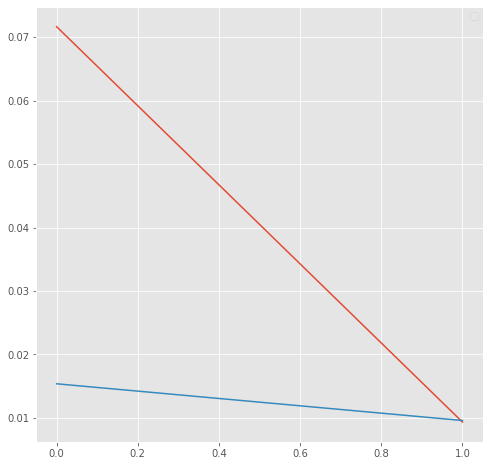

In [17]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend()
plt.show()